# Implementation of an Autoencoder (VAE)
#### based on the VE implementation and https://sannaperzon.medium.com/paper-summary-variational-autoencoders-with-pytorch-implementation-1b4b23b1763a
## Simple linear VAE with one layer into hidden (latent) space 748 -> 256 -> 12 and back 12 -> 256 -> 748

#### Build for MINST datasets

In [1]:
#import os
#os.environ['MKL_NUM_THREADS'] = '1'
#os.environ['NUMEXPR_NUM_THREADS'] = '1'
#os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.transforms import ToTensor

In [2]:
batch_size = 256

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_dataloader = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"   ### needed if Nvidia GPU is available and wanted to use the GPU
print(f"Using {device} device")

Using cuda device


In [4]:
### Building the neural network structure ####

dim_encoder_decoder=784
dim_hidden=256
dim_latent=16

class VAE(nn.Module):
    def __init__(self, dim_encoder_decoder=784, dim_hidden=256, dim_latent=16):
        super(VAE , self).__init__()
        
        self.decoder = nn.Sequential(                             # sequential operation of the following code:
            nn.Linear(dim_latent, dim_hidden),                    # decoding laten layer (16 -> 256 nodes)
            nn.ReLU(),                                            # activation function f(x) = max(0, x)
            nn.Linear(dim_hidden, dim_encoder_decoder),           # reconstruction of image (256 -> 784)
            nn.Sigmoid() #nn.Softmax()                            # rescale values between ]0,1[ by the sigmoidal function
        )
        
        self.encoder_layer = nn.Sequential(                       # sequential operation of the following code:
            nn.Linear(dim_encoder_decoder, dim_hidden),           # decoding laten layer (784 -> 256 nodes)
            nn.ReLU(),                                            # activation function
        )
        
        self.hidden_to_mu = nn.Linear(dim_hidden, dim_latent)     # hidden layer in dim_latent for mu
        self.hidden_to_sigma = nn.Linear(dim_hidden, dim_latent)  # hidden layer in dim_latent for sigma


    def encoder(self, x):
        hidden_layer = self.encoder_layer(x)                      #
        mu = self.hidden_to_mu(hidden_layer)                      # get the mean
        sigma = self.hidden_to_sigma(hidden_layer)                # get the standard devation
        return mu , sigma                                         # return the encoded 

        
    def forward(self, x):                                         # 
        mu, sigma = self.encoder(x)                               # compute the variance and mean of a reduced dim
        epsilon = torch.randn_like(sigma)                         # random noice ### "Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1"
        z = mu + sigma*epsilon                                    # reparametrization # compute latent layer from reduced dim of mu and sigma and some random noice
        decoded = self.decoder(z)                                 # decode latent layer
        return decoded , mu, sigma , z                            # return the decoded vector, mean, standard devation, latent vector


model = VAE().to(device) #### this is needed for cuda


In [5]:
loss_fn = nn.MSELoss()                                        ### nn.MSELoss() (Mean Square Error) for regression tasks
loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4, )#

Epoch process: 92.0%; Total progress: 100%|██████████| 50/50 [07:52<00:00,  9.45s/it]


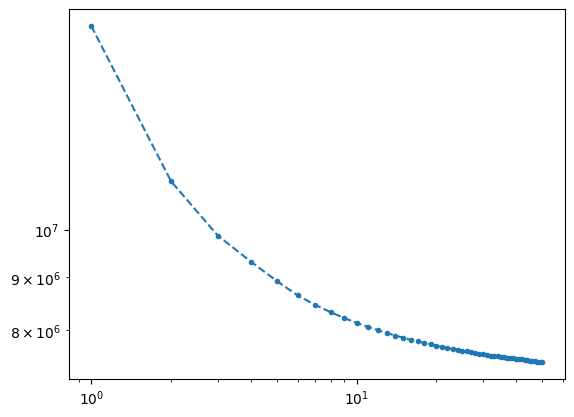

In [6]:
from tqdm import tqdm
n_epochs = 50

list_loss = []
torch.manual_seed(42)
loop = tqdm(np.arange(0,n_epochs))
for epoch in loop:
    loss_total = 0
    for batch , (X, label) in enumerate(train_dataloader):
        X = X.reshape(-1, dim_encoder_decoder).to(device)
        pred , mu, sigma , _ = model(X)
        re_loss = loss_fn(pred, X)
        kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        loss = re_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        #loop.set_postfix(loss_total=loss_total)
        loop.set_description(f"Epoch process: {round((batch+1)*100/batch_size,0)}%; Total progress")
    list_loss.append(loss_total)
    
plt.plot([i+1 for i,x in enumerate(list_loss)], list_loss,"--.")
plt.yscale("log")
plt.xscale("log")
plt.show()

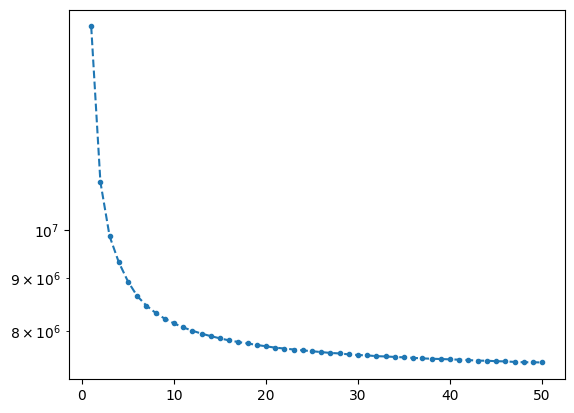

In [7]:
plt.plot([i+1 for i,x in enumerate(list_loss)], list_loss,"--.")
plt.yscale("log")
#plt.xscale("log")
plt.show()

In [8]:
import pandas as pd

In [9]:
loss_MSE = nn.MSELoss()  
loss_CrossEntropy = nn.CrossEntropyLoss()
loss_BCE = nn.BCELoss(reduction="sum")

loss_MSE_SUM = 0
loss_CrossEntropy_SUM = 0
loss_BCE_SUM = 0
encoded_samples = []
for sample, label in tqdm(mnist_test):
    img = sample[0].unsqueeze(0).reshape(-1, 28*28).to(device)
    # Encode image
    model.eval()
    with torch.no_grad():
        decoded_img , mu, sigma , z  = model(img)
    
    loss_MSE_SUM += loss_MSE(decoded_img, img)
    loss_CrossEntropy_SUM += loss_CrossEntropy(decoded_img, img)
    loss_BCE_SUM += loss_BCE(decoded_img, img)
    
print("loss_MSE_SUM: ",loss_MSE_SUM.item(), " ; \n loss_CrossEntropy_SUM: ", 
     loss_CrossEntropy_SUM.item(), " ; \n loss_BCE_SUM: ", loss_BCE_SUM.item())

100%|██████████| 10000/10000 [00:09<00:00, 1012.93it/s]

loss_MSE_SUM:  182.52830505371094  ; 
 loss_CrossEntropy_SUM:  6382696.5  ; 
 loss_BCE_SUM:  918033.6875


### STUFF THAT SHOULD BE NEW NOTEBOOK AND INCLUDES VA

In [10]:
import pandas as pd
encoded_samples = []
for sample in tqdm(mnist_data):
    img = sample[0].unsqueeze(0).reshape(-1, 28*28).to(device)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        decoded_img , mu, sigma , encoded_img  = model(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"latent {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
VAE_pd = pd.DataFrame(encoded_samples)
VAE_pd.shape

100%|██████████| 60000/60000 [00:46<00:00, 1299.52it/s]


(60000, 17)

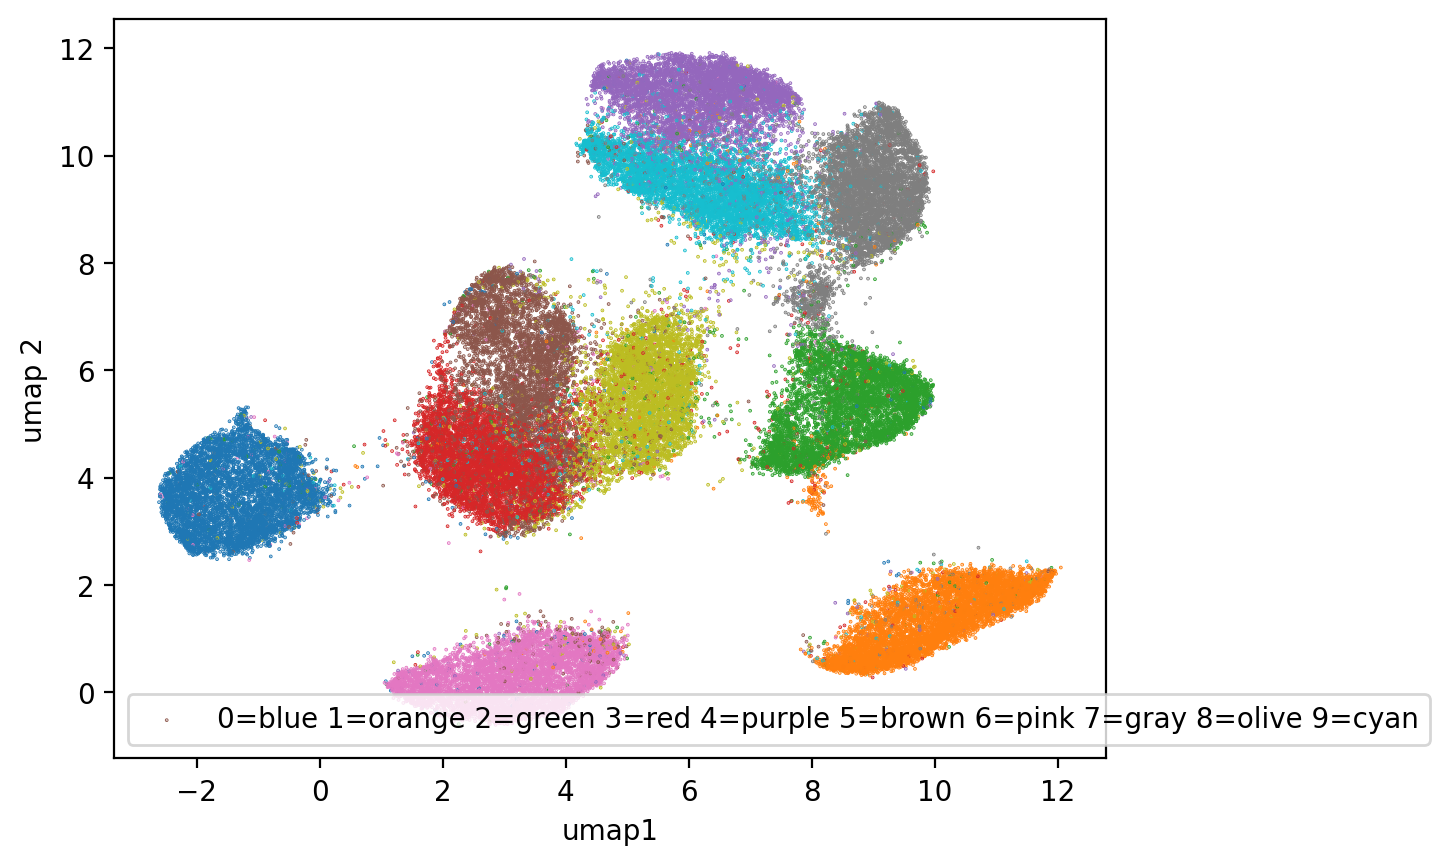

In [12]:
from umap import UMAP

# Initialize UMAP model with 2 components
umap = UMAP(n_components=2)

# Fit the model and transform the data
umap_results = umap.fit_transform(VAE_pd.drop(['label'],axis=1))

color = ['tab:blue', 'tab:orange', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
            'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_map = []
test = [color_map.append(color[int(i[0])]) for i in VAE_pd.label.astype(str)]
sizes = [0.1 for i in umap_results[:,0:1]]
plt.figure(dpi=200)
plt.scatter([i[0] for i in umap_results[:,0:1]], [i[0] for i in umap_results[:,1:]], sizes ,color=color_map)
plt.xlabel('umap1')
plt.ylabel('umap 2')
plt.legend(["0=blue 1=orange 2=green 3=red 4=purple 5=brown 6=pink 7=gray 8=olive 9=cyan"])
plt.show()


### Visulaze the VAE in UMAP to make sure the model does something we want

In [13]:
encoded_raw = []
for sample in tqdm(mnist_data):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    encoded_img = img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_raw.append(encoded_sample)
encoded_raw = pd.DataFrame(encoded_raw)
encoded_raw.shape

100%|██████████| 60000/60000 [00:49<00:00, 1217.91it/s]


(60000, 785)

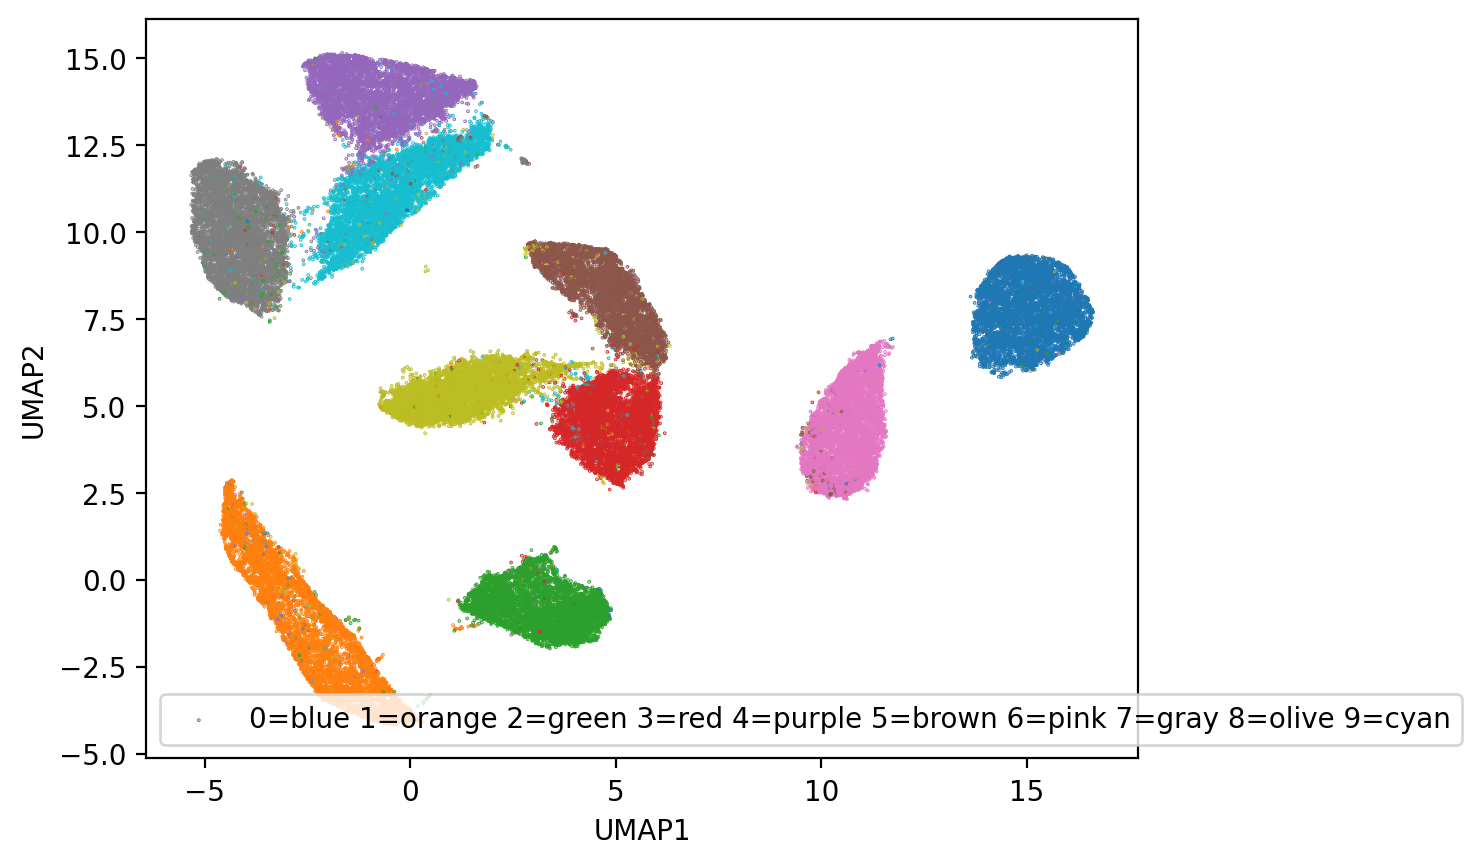

In [14]:
umap_results = umap.fit_transform(encoded_raw.drop(['label'],axis=1))

color = ['tab:blue', 'tab:orange', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
            'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_map = []
test = [color_map.append(color[int(i[0])]) for i in encoded_raw.label.astype(str)]
sizes = [0.1 for i in umap_results[:,0:1]]
plt.figure(dpi=200)
plt.scatter([i[0] for i in umap_results[:,0:1]], [i[0] for i in umap_results[:,1:]], sizes ,color=color_map)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(["0=blue 1=orange 2=green 3=red 4=purple 5=brown 6=pink 7=gray 8=olive 9=cyan"])
plt.show()


### 2d-UMAP of raw data

In [16]:
# Initialize UMAP model with 16 components on raw data
umap = UMAP(n_components=16)

# Fit the model and transform the data
umap_results_raw = umap.fit_transform(encoded_raw.drop(['label'],axis=1))

In [17]:
umap_results_raw_T = umap_results_raw.T

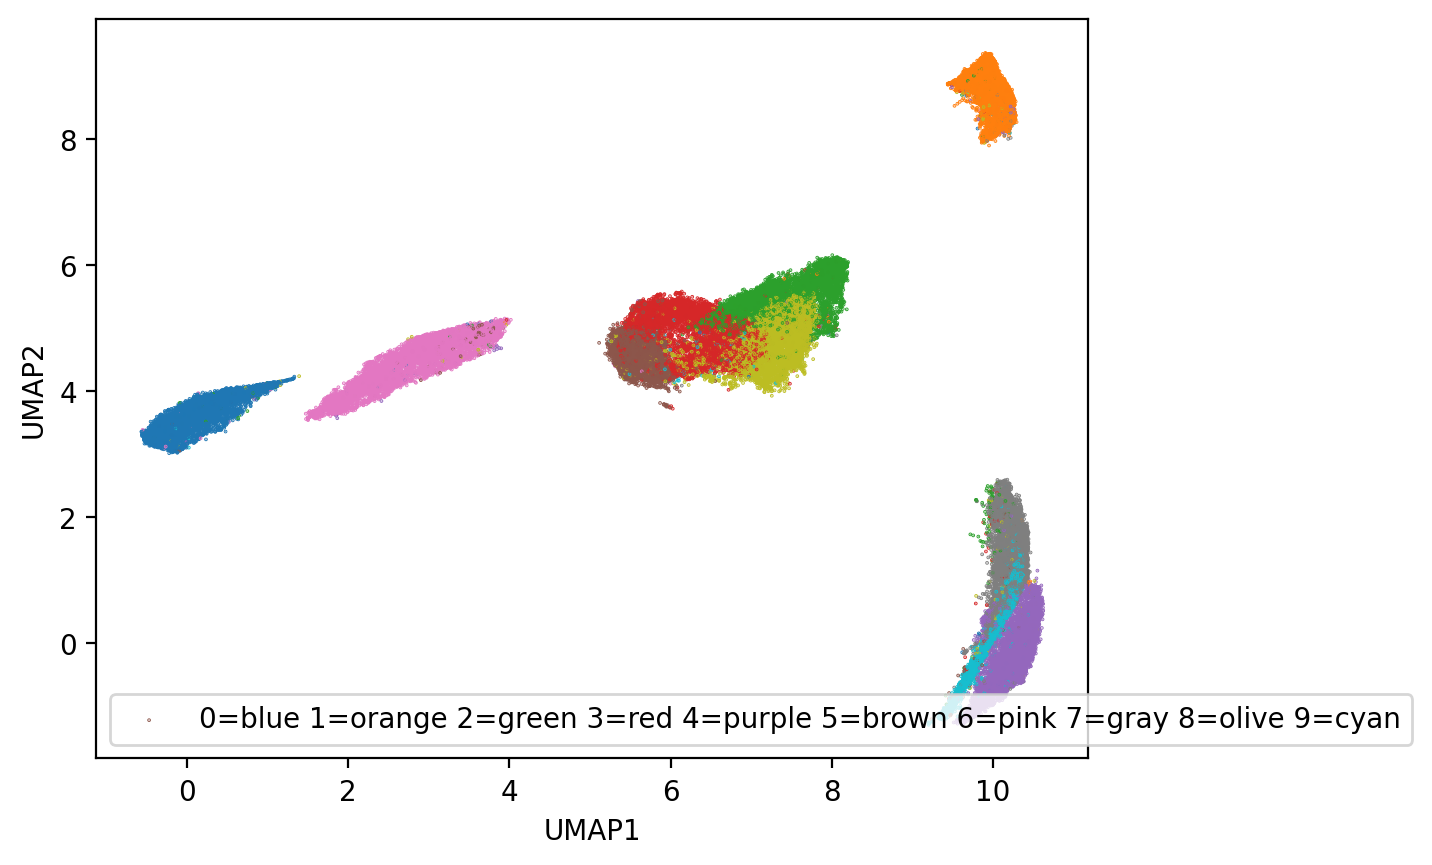

In [18]:
color_map = []
test = [color_map.append(color[int(i[0])]) for i in encoded_raw.label.astype(str)]
sizes = [0.1 for i in umap_results[:,0:1]]
plt.figure(dpi=200)

plt.scatter(umap_results_raw_T[0],umap_results_raw_T[1] , sizes ,color=color_map)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(["0=blue 1=orange 2=green 3=red 4=purple 5=brown 6=pink 7=gray 8=olive 9=cyan"])
plt.show()

In [19]:
umap_raw = []
for i,sample in enumerate(tqdm(umap_results_raw)):
    umap_ = {f"UMAP {i}": enc for i, enc in enumerate(sample)}
    umap_['label'] = mnist_data[i][1]
    umap_raw.append(umap_)
umap_pd = pd.DataFrame(umap_raw)
umap_pd.shape

100%|██████████| 60000/60000 [00:09<00:00, 6394.75it/s]


(60000, 17)

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
PCA_raw = pca.fit_transform(encoded_raw.drop(['label'],axis=1))
PCA_raw_T = PCA_raw.T
print(PCA_raw_T.shape)

(16, 60000)


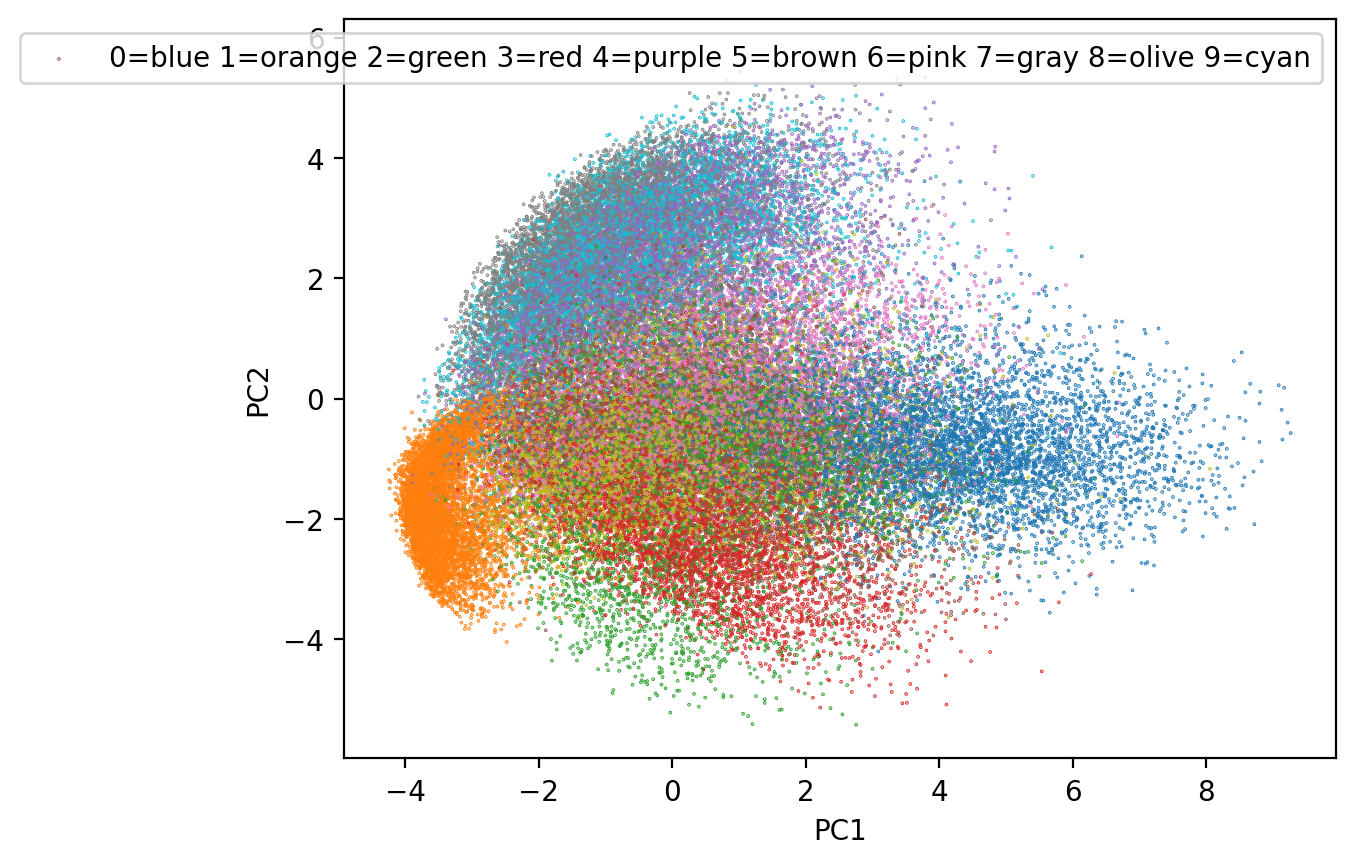

In [21]:
color_map = []
test = [color_map.append(color[int(i[0])]) for i in encoded_raw.label.astype(str)]
sizes = [0.1 for i in PCA_raw_T[0]]
plt.figure(dpi=200)
plt.scatter(PCA_raw_T[0],PCA_raw_T[1] , sizes,color=color_map)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(["0=blue 1=orange 2=green 3=red 4=purple 5=brown 6=pink 7=gray 8=olive 9=cyan"])
plt.show()

In [22]:
PCA_raw_ = []
for i,sample in enumerate(tqdm(PCA_raw)):
    PCA_ = {f"PC {i}": enc for i, enc in enumerate(sample)}
    PCA_['label'] = mnist_data[i][1]
    PCA_raw_.append(PCA_)
PCA_pd = pd.DataFrame(PCA_raw_)
PCA_pd.shape

100%|██████████| 60000/60000 [00:09<00:00, 6421.73it/s]


(60000, 17)

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
PCA_X = PCA_pd.drop(['label'],axis=1)
UMAP_X = umap_pd.drop(['label'],axis=1)
VAE_X = VAE_pd.drop(['label'],axis=1)

# kmeans with k=10
kmeans_PCA = KMeans(n_clusters=10,n_init=100, random_state=0).fit_predict(PCA_X)
kmeans_UMAP = KMeans(n_clusters=10,n_init=100, random_state=0).fit_predict(UMAP_X)
kmeans_VAE = KMeans(n_clusters=10,n_init=100, random_state=0).fit_predict(VAE_X)

PCA_pd["kmean_label"] = kmeans_PCA #.labels_.astype(str)
umap_pd["kmean_label"] = kmeans_UMAP #.labels_.astype(str)
VAE_pd["kmean_label"] = kmeans_VAE #.labels_.astype(str)

In [28]:
umap_pd

,UMAP 0,UMAP 1,UMAP 2,UMAP 3,UMAP 4,UMAP 5,UMAP 6,UMAP 7,UMAP 8,UMAP 9,UMAP 10,UMAP 11,UMAP 12,UMAP 13,UMAP 14,UMAP 15,label,kmean_label
0,5.597436,4.775445,6.151727,9.242136,7.000657,1.681897,4.843574,4.899993,6.316683,4.469128,4.060167,3.172024,5.171918,4.797750,5.021147,5.344359,5,2
1,0.263632,3.833240,1.167022,5.311096,5.582978,3.023278,5.046696,4.576560,5.806767,5.696388,3.541291,3.777992,5.150889,4.327508,4.971898,5.488879,0,3
2,10.000676,-0.976214,4.230200,4.093853,5.385836,1.969467,7.157930,4.195516,5.691645,5.501229,3.824441,3.627970,5.181834,4.801618,4.980971,5.173508,4,0
3,10.071483,8.151535,3.229665,6.049983,2.912197,2.338560,4.967176,4.400552,5.318228,5.463721,3.982874,3.842753,5.297041,4.794955,5.081506,5.411897,1,6
4,10.202459,0.489871,3.891529,5.106486,5.370131,2.885398,5.030753,4.530571,5.663735,5.996868,3.959383,3.727558,5.134468,4.825244,5.069666,5.752546,9,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,7.408246,5.236881,4.785802,9.483139,6.563974,1.775736,4.558333,4.843635,5.388597,7.051057,4.365524,5.702964,5.249290,4.794044,4.933280,5.084302,8,8
59996,6.195988,5.356685,4.778074,10.602615,7.777207,2.578781,4.880418,3.387988,5.323276,5.354154,3.902027,2.592377,5.329990,4.306448,5.135551,4.757084,3,2
59997,5.704196,4.591866,6.180211,9.158666,7.046351,1.560297,4.860489,4.806859,6.238580,4.560257,4.060216,3.321378,5.168269,4.847785,4.999939,5.399720,5,2
59998,2.940009,4.690295,8.916794,5.724570,4.924362,3.331115,4.763620,5.288547,6.350148,5.058858,3.204971,3.816937,5.164963,5.035447,5.097757,5.424356,6,5


In [29]:
PCA_pd

,PC 0,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,PC 11,PC 12,PC 13,PC 14,PC 15,label,kmean_label
0,0.486010,-1.226174,-0.096125,-2.179436,-0.107019,-0.911748,0.918324,0.627228,-1.426303,0.770292,0.806836,-0.961744,-0.405565,2.932449,0.818531,1.443145,5,5
1,3.967524,-1.156297,2.338577,-1.806929,-3.244256,-0.713664,-0.176659,-0.417158,0.164314,0.590037,-1.170836,-0.480120,-1.279183,0.408837,-0.254852,-0.561004,0,4
2,-0.203331,1.537939,-0.739273,2.043173,-1.202740,-0.007251,-3.369317,1.438334,-0.444477,-0.692568,1.705283,-0.660057,0.677183,0.436880,0.205518,0.085357,4,9
3,-3.133830,-2.381161,1.073137,0.415213,-0.007291,2.743557,-1.857571,-0.267539,1.191713,0.038887,-1.728719,-0.729734,0.934951,0.666823,-0.493460,0.299501,1,6
4,-1.501000,2.864873,0.064125,-0.947840,0.384924,0.169617,-0.360068,-1.591095,0.884208,0.414993,-1.394894,1.763462,-1.016833,-1.236406,0.865664,-0.546499,9,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.390673,-1.150883,0.533096,-1.361273,1.193229,0.929335,-1.954760,-0.935093,-1.937300,1.255073,0.483587,0.939418,1.925913,-1.317892,0.777969,-1.070702,8,5
59996,0.599049,-2.697649,-0.348760,-2.549081,0.778059,0.724762,-1.910725,1.982452,-2.627202,0.115512,-0.004333,1.506002,0.265464,0.582825,0.323363,-0.994962,3,5
59997,-0.698251,0.627746,-1.010232,-2.802557,-0.824696,-1.813182,-1.821788,-0.713896,-0.356547,1.057608,0.647392,-1.318463,0.726430,0.379479,0.584623,0.338228,5,7
59998,0.512179,-0.021938,2.015144,1.343933,-2.043731,-2.119544,-0.421199,0.559639,-0.073517,-0.367122,0.036192,-0.636904,-1.599899,-0.331421,0.850694,-0.396020,6,4


In [30]:
VAE_pd

,latent 0,latent 1,latent 2,latent 3,latent 4,latent 5,latent 6,latent 7,latent 8,latent 9,latent 10,latent 11,latent 12,latent 13,latent 14,latent 15,label,kmean_label
0,0.879032,-1.090337,-0.253269,-1.666872,0.277339,1.141441,-1.859309,0.468386,-0.369228,-1.071193,0.123383,0.575704,2.388115,-0.042510,1.699030,0.182750,5,1
1,0.402268,0.692435,0.127846,-0.132207,0.468320,0.621619,1.625384,1.038784,-0.627150,-0.577971,0.871826,-1.019693,-0.090514,-1.787055,-0.595661,2.252091,0,8
2,0.042954,-0.094299,2.010088,-0.473545,-1.152335,-2.395129,1.906734,1.666506,0.751040,-0.608603,-0.023943,1.777467,-1.193778,-0.274563,0.089167,-0.246628,4,6
3,0.416465,-1.821985,0.418344,0.045011,1.821541,-1.458572,-1.123261,-0.329517,0.796010,0.671654,0.149886,-0.700953,-0.588671,0.947223,1.092379,-1.224074,1,4
4,-0.914913,-0.026587,0.100964,1.745655,-0.788681,-1.521446,0.991322,0.756331,1.394905,0.906564,0.267532,0.671833,1.525547,1.447366,-1.188701,0.862254,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.803142,-2.290921,-0.770618,-0.371244,0.325102,-1.498786,-1.190751,0.069741,-0.844545,0.091103,-2.357230,0.206082,-0.416032,-0.070266,-0.260450,0.231648,8,3
59996,-1.024929,-1.792906,0.627344,2.015088,0.330113,0.203574,1.122419,-0.520227,-1.815797,-0.499442,0.137629,1.109652,-0.426153,-0.935662,0.211407,-0.004907,3,1
59997,-0.184074,-1.907068,0.665531,0.847913,-1.299222,-1.751810,0.352331,0.187333,-0.628531,-2.160981,0.660117,1.247200,-1.061108,0.541413,-0.378923,1.244582,5,1
59998,-0.080458,0.899609,0.415185,0.416633,1.065167,-1.647899,-0.381178,-0.464808,0.368621,-0.880693,0.952292,-1.048708,-0.019733,-0.908610,-0.031326,1.326026,6,2
